<a href="https://www.kaggle.com/code/nigamshitij/random-forest-classifier-tests?scriptVersionId=177003992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
#boilerplates

from fastai.imports import *
np.set_printoptions(linewidth = 130)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('/kaggle/input/titanic')
else:
    import zipfile, kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [4]:
# extract csv
dataframe = pd.read_csv(path/'train.csv')
test_dataframe = pd.read_csv(path/'test.csv')
modes = dataframe.mode().iloc[0] # get the first mode for each field

# process data
def process_data(dataframe):
    dataframe['Fare'] = dataframe['Fare'].fillna(0)
    dataframe.fillna(modes, inplace = True)
    dataframe['LogFare'] = np.log1p(dataframe['Fare'])
    dataframe['Embarked'] = pd.Categorical(dataframe['Embarked']) # convert to category variable instead of dummy
    dataframe['Sex'] = pd.Categorical(dataframe['Sex']) # convert to category instead of dummy

process_data(dataframe)
process_data(test_dataframe)
dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765


In [5]:
test_dataframe.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,B96 B98,Q,2.178064
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,B96 B98,S,2.079442
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,B96 B98,Q,2.369075
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,B96 B98,S,2.268252
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,B96 B98,S,2.586824


In [6]:
# classify variables
categorical_var = ["Sex", "Embarked"]
continuous_var = ["Age", "SibSp", "Parch", "LogFare", "Pclass"]
dependent_var = "Survived"

# test
print(test_dataframe['Sex'].head())
print(test_dataframe['Sex'].cat.codes.head())

0      male
1    female
2      male
3      male
4    female
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']
0    1
1    0
2    1
3    1
4    0
dtype: int8


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


[Text(0.5, 1.0, 'Histogram')]

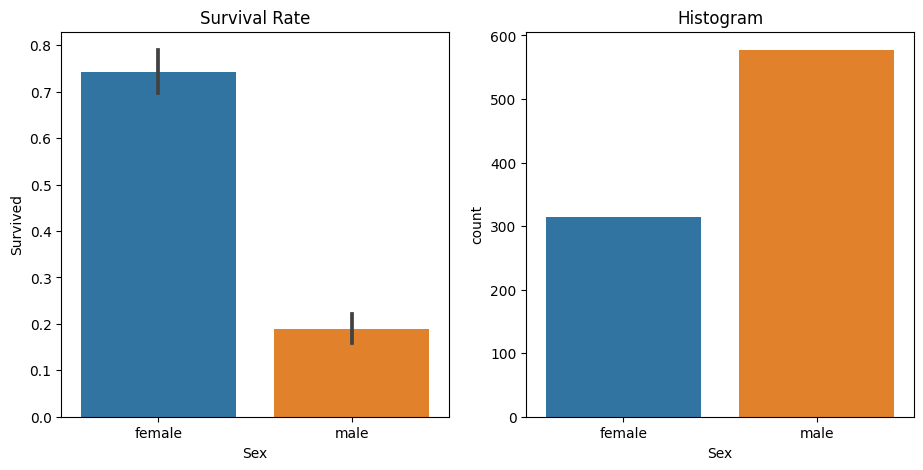

In [7]:
# begin basic splits
import seaborn as sns

# test a binary split across sex to see basic survival rates
figure, axis = plt.subplots(1, 2, figsize = (11,5))
sns.barplot(data = dataframe, y = dependent_var, x = "Sex", ax = axis[0]).set(title = "Survival Rate")
sns.countplot(data = dataframe, x = "Sex", ax = axis[1]).set(title = "Histogram")

In [8]:
# pd.read_csv??
# DataFrame[].apply??

In [9]:
# split data into training & validation
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)

# apply applies a function
# convert categories to their coded format
training_dataframe, validation_dataframe = train_test_split(dataframe, test_size = 0.25)
training_dataframe[categorical_var] = training_dataframe[categorical_var].apply(lambda x: x.cat.codes)
validation_dataframe[categorical_var] = validation_dataframe[categorical_var].apply(lambda x: x.cat.codes)
test_dataframe[categorical_var] = test_dataframe[categorical_var].apply(lambda x: x.cat.codes)

# create function to extract dependent (y) and independent (x) variables from a dataframe
def get_xy(dataframe):
    xs = dataframe[categorical_var + continuous_var].copy()
    return xs, dataframe[dependent_var] if dependent_var in dataframe else None
#     if dependent_var in dataframe:
#         return xs, dataframe[dependent_var]
#     else:
#         return xs, None

# extract x and y from training and validation dataframes
training_x, training_y = get_xy(training_dataframe)
validation_x, validation_y = get_xy(validation_dataframe)
test_x, _ = get_xy(test_dataframe)

# get basic predictions
print(training_x['Sex'].head())

298    1
884    1
247    0
478    1
305    1
Name: Sex, dtype: int8


In [10]:
# get predictions and calculate mse (simple binary split)
predictions_y = validation_x['Sex'] == 0

# calculate mean absolute error
from sklearn.metrics import mean_absolute_error
mae_sex = mean_absolute_error(y_true = validation_y, y_pred = predictions_y)
print("Mean absolute error using sex = ", f'{mae_sex:.2f}')

Mean absolute error using sex =  0.22


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean absolute error using logfare =  0.34


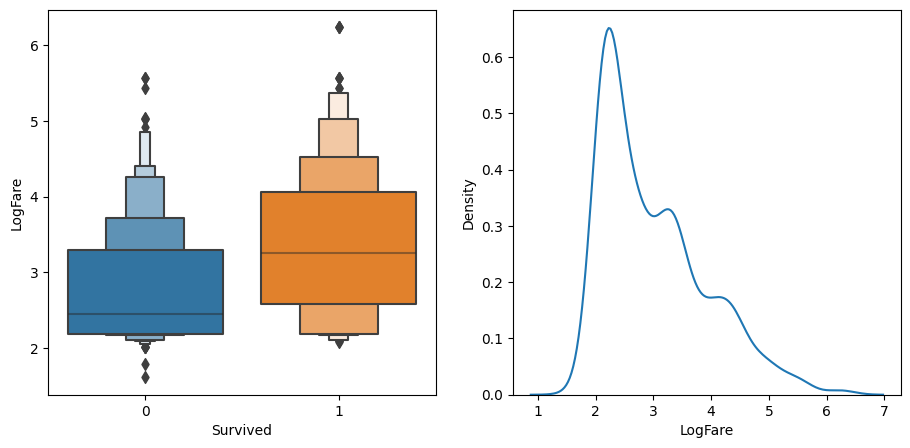

In [11]:
# use log fare exploratory
dataframe_fare = training_dataframe[training_dataframe['LogFare']>0]
figures, axis = plt.subplots(1, 2, figsize = (11,5))
sns.boxenplot(data = dataframe_fare, x = dependent_var, y = "LogFare", ax = axis[0])
sns.kdeplot(data = dataframe_fare, x = "LogFare", ax = axis[1])

# predictions based on logfare 50th percentile
predictions_y = validation_x['LogFare'] > 2.7
mae_logfare = mean_absolute_error(y_true = validation_y, y_pred = predictions_y)
print("Mean absolute error using logfare = ", f'{mae_logfare:.2f}')

In [12]:
# calculate impurity for nodes

# define score calculation of specific side
def _side_score(side, y):
    total = side.sum()
    if total <= 1:
        return 0
    return y[side].std()*total # calculate standard deviation of the dependent variable (y) and multiply by total items

def score(column_being_split, y, split_value):
    left_hand_side = column_being_split <= split_value
    # right_hand_side = column_being_split > split_value
    # print(right_hand_side == ~left_hand_side)
    # sum up scores on both sides (summation side stdev x units per side) and divide by all units
    return (_side_score(left_hand_side, y) + _side_score(~left_hand_side, y))/len(y)

split_score_sex = score(training_x['Sex'], training_y, 0.5)
split_score_logfare = score(training_x['LogFare'], training_y, 2.7)

# lower is better because less standard deviation of dependent variable, more similar they are within that side
print("Score for splitting sex at 0.5: ", f'{split_score_sex:.2f}')
print("Score for splitting logfare at 2.7:", f'{split_score_logfare:.2f}')

Score for splitting sex at 0.5:  0.41
Score for splitting logfare at 2.7: 0.47


In [13]:
# automatic best split score calculator
def minimum_column(dataframe, column_name):
    column, y = dataframe[column_name], dataframe[dependent_var]
    uniques = column.dropna().unique() # drop NAs and get unique
    scores = np.array([score(column, y, split_val) for split_val in uniques if not np.isnan(split_val)])
    index = scores.argmin()
    return uniques[index], scores[index]

# test for age
minimum_column(training_dataframe, 'Age')

# collect all columns
columns = categorical_var + continuous_var

# create dict
min_columns_dict = {col_name: minimum_column(training_dataframe, col_name) for col_name in columns}
min_columns_dict

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

In [14]:
# np.append??

# create decision tree based on male/female split
columns.remove("Sex")
ismale = training_dataframe['Sex'] == 1
male_only_data, female_only_data = training_dataframe[ismale], training_dataframe[~ismale]

# generate lowest score per column within female data
min_col_female = {col_name: minimum_column(female_only_data, col_name) for col_name in columns}
min_key_female, (min_cutoff_female, min_val_female) = min(min_col_female.items(), key = lambda x: x[1][1])
print("The lowest score col for females is: ", min_key_female, "| Cutoff: ", min_cutoff_female, "| Score: ", f'{min_val_female:.2f}')

# generate lowest score per column within male data
min_col_male = {col_name: minimum_column(male_only_data, col_name) for col_name in columns}
min_key_male, (min_cutoff_male, min_val_male) = min(min_col_male.items(), key = lambda x: x[1][1])
print("The lowest score col for males is: ", min_key_male, "| Cutoff: ", min_cutoff_male, "| Score: ", f'{min_val_male:.2f}')

The lowest score col for females is:  Pclass | Cutoff:  2 | Score:  0.33
The lowest score col for males is:  Age | Cutoff:  6.0 | Score:  0.37


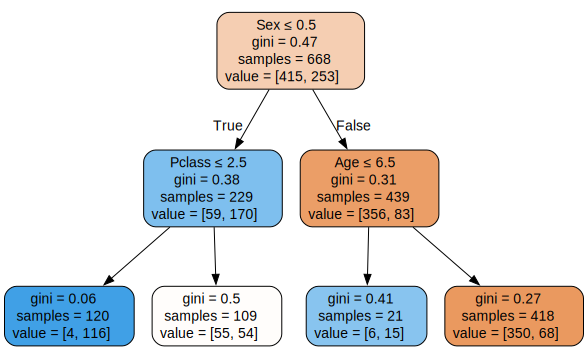

In [15]:
# use sklearn decision tree classifier to automate
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# create tree with max nodes, insert training features
m = DecisionTreeClassifier(max_leaf_nodes = 4).fit(X = training_x, y = training_y)

# draw tree function
def draw_tree(dt, dataframe, size = 10, ratio = 0.6, precision = 2, **kwargs):
    s = export_graphviz(
        decision_tree = dt,
        out_file = None,
        feature_names = dataframe.columns,
        filled = True,
        rounded = True,
        special_characters = True,
        rotate = False,
        precision = precision,
        **kwargs
    )
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, training_x, size = 10)

MSE =  0.18


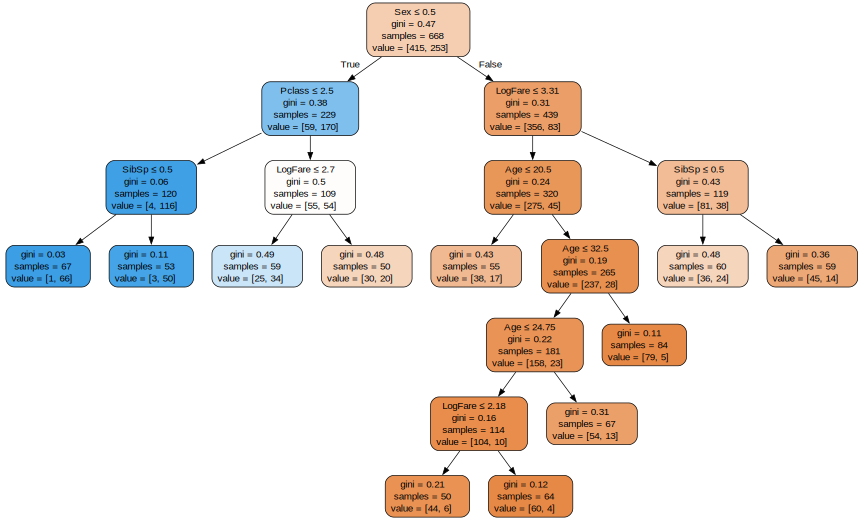

In [16]:
# gini tends to 0 when it is perfectly split; higher is worse (1-classAratio^2-classBratio^2)

model = DecisionTreeClassifier(min_samples_leaf = 50)
model.fit(X = training_x, y = training_y)
mae = mean_absolute_error(validation_y, model.predict(validation_x))
print("MSE = ", f'{mae:.2f}')
draw_tree(model, training_x, size = 12)

In [17]:
# convert to csv
def submission(predictions, suffix):
    test_dataframe['Survived'] = predictions
    sub_dataframe = test_dataframe[['PassengerId', 'Survived']]
    sub_dataframe.to_csv(f'sub-{suffix}.csv', index = False)

submission(model.predict(test_x), suffix = 'tree')

In [18]:
!head sub-tree.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [19]:
# random.choice??
# n = len(training_y)
# random.choice(n, int(n*0.75))

In [20]:
# create multiple forests

# create a single tree which runs on 75% the size of training data
def get_tree(proportion = 0.75):
    n = len(training_y) # get max length of training data
    indexes = random.choice(n, int(n*proportion)) # generate random numbers = 75% of the total length of training data, from 0 to n
    return DecisionTreeClassifier(min_samples_leaf = 5).fit(training_x.iloc[indexes], training_y.iloc[indexes])

# create 100 trees
trees = [get_tree() for t in range(100)]

# get predictions for all trees using validation data
all_probs = [t.predict(validation_x) for t in trees]

# get average of all predictions
avg_probs = np.stack(all_probs).mean(0)

mae = mean_absolute_error(validation_y, avg_probs)
print("Multi forest MAE = ", f'{mae:.2f}')

Multi forest MAE =  0.23


Random Forest MAE =  0.19


<Axes: ylabel='cols'>

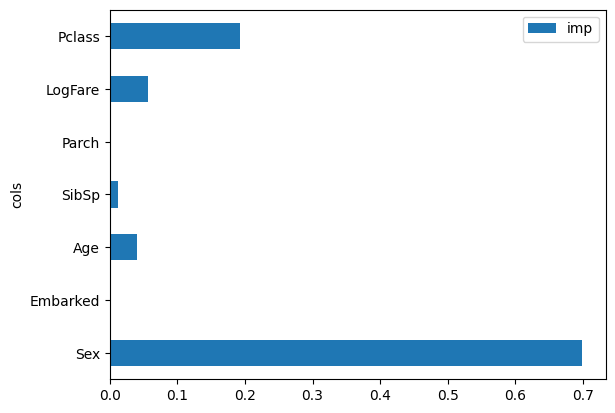

In [21]:
# create random forests

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(100, min_samples_leaf = 5)
random_forest.fit(training_x, training_y)
mae = mean_absolute_error(validation_y, random_forest.predict(validation_x))
print("Random Forest MAE = ", f'{mae:.2f}')
pd.DataFrame(dict(cols = training_x.columns, imp = model.feature_importances_)).plot('cols', 'imp', 'barh')